## Define natural priors

In [7]:
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'pdf')

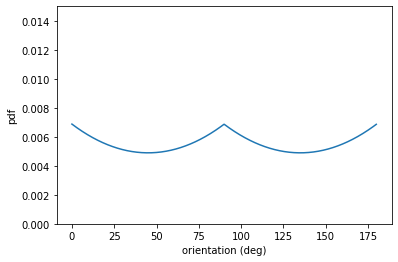

In [75]:
# "Natural prior" (Girshick et al. 2011, fig.6)
n_ori = 1000
a = 2e-4
b = 1

dori = 180 / n_ori
stim_dirs = np.float32(np.arange(0, 180, dori))
stim_p = np.zeros(n_ori)
midindx = np.argmin(np.abs(stim_dirs-90))

stim_p[:midindx] = a*(np.arange(0, stim_dirs[midindx], stim_dirs[midindx] / midindx)-45)**2 + b
stim_p[midindx:] = a*(np.arange(stim_dirs[midindx+1],
                               180, (180-stim_dirs[midindx+1]) / (n_ori-midindx)
                              )-135)**2 + b
plt.figure()
stim_p = stim_p/np.sum(stim_p)
plt.plot(stim_dirs,stim_p/dori)
plt.ylim([0,0.015])
plt.xlabel('orientation (deg)')
plt.ylabel('pdf')

## Train network from stimuli distributed with the natural statistics

In [32]:
import sys, os, time

import copy
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../')
from det_rnn import *
import det_rnn.train as train_utils
import tensorflow as tf
from det_rnn.train.model import Model

model_dir = "/Users/JRyu/github/det_rnn/experiments/naturalprior/200622/"
os.makedirs(model_dir, exist_ok=True)

In [10]:
# Generate stimulus

# training set
par_train = copy.deepcopy(par)
# use "natural prior"
par_train['stim_dist'] = 'natural'
par_train['natural_a'] = 2e-4
par_train['n_ori'] = 1000 # make it somewhat continuous
par_train = update_parameters(par_train)
stim_train = Stimulus(par_train)

# testing set; for testing the 24 orientations
par_test = copy.deepcopy(par)
par_test = update_parameters(par_test)
stim_test = Stimulus(par_test)   # the argument `par` may be omitted

In [23]:
ti_spec = train_utils.gen_ti_spec(stim_train.generate_trial()) # what does this do?
ti_spec
ti_spec['neural_input'].shape

TensorShape([None, 128, 26])

In [30]:
###### Train network ######
N_iter = 1000
N_save = 10  # save model every N_save iterations

# define model
hp = train_utils.hp
hp['learning_rate'] = 2e-4
model = Model(hp=hp)

ti_spec = train_utils.gen_ti_spec(stim_train.generate_trial())

Y shape = (600, 128, 25)
normalize output with softmax..
norm shape = (600, 128, 1)
I think there is no need to normalize again...
pseudo_mean shape = (600, 128)


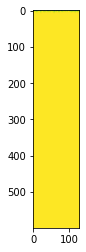

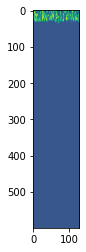

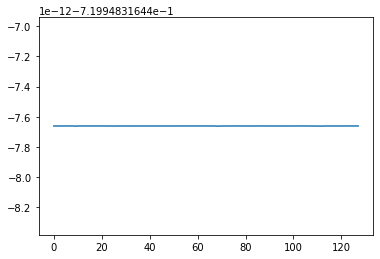

In [41]:
train_data = train_utils.tensorize_trial(stim_train.generate_trial())
Y, Loss = model(train_data, hp)

train_data, Y, Loss, 

print('Y shape = ' + str(Y.shape))
print('normalize output with softmax..\n')
cenoutput = tf.nn.softmax(Y, axis=2).numpy()
post_prob = cenoutput[:, :, par_train['n_rule_output']:] #shape = T X B X neurons
norm = np.sum(post_prob, axis=2, keepdims=True)

print('norm shape = ' + str(norm.shape))
plt.figure()
plt.imshow(np.squeeze(norm))
#print(np.squeeze(norm)) 
print('I think there is no need to normalize again...\n')
post_prob = post_prob / (
        np.sum(post_prob, axis=2, keepdims=True) + np.finfo(np.float32).eps)  # Dirichlet normalization

post_support = np.linspace(0, np.pi, post_prob.shape[2], endpoint=False) + np.pi / post_prob.shape[2] / 2
pseudo_mean = np.arctan2(post_prob @ np.sin(2 * post_support),
                         post_prob @ np.cos(2 * post_support)) / 2

print('pseudo_mean shape = ' + str(pseudo_mean.shape))
plt.figure()
plt.imshow(np.squeeze(pseudo_mean))

estim_sinr = (np.sin(2 * pseudo_mean[par_train['design_rg']['estim'], :])).mean(axis=0)
estim_cosr = (np.cos(2 * pseudo_mean[par_train['design_rg']['estim'], :])).mean(axis=0)
estim_mean = np.arctan2(estim_sinr, estim_cosr) / 2
plt.figure()
plt.plot(estim_mean)

perf = np.mean(np.cos(2. * (train_data['stimulus_ori'].numpy() * np.pi 
                            / par['n_ori'] - estim_mean)))

In [ ]:
alllosses =[]
performance_train = {'perf': [], 'loss': [], 'perf_loss': [], 'spike_loss': []}
performance_test = {'perf': [], 'loss': [], 'perf_loss': [], 'spike_loss': []}
for iter_n in range(N_iter+1):
    # train on testing set
    train_data = train_utils.tensorize_trial(stim_train.generate_trial())
    Y, Loss = model(train_data, hp)

    performance_train = train_utils.append_model_performance(performance_train,
                                                             train_data, Y, Loss, par_train)
    # append performance on testing set
    test_data = train_utils.tensorize_trial(stim_test.generate_trial())
    performance_test = train_utils.append_model_performance(performance_test,
                                                             test_data, Y, Loss, par_test)

    if (iter_n % N_save) == 0:
        print('Training performance: \n')
        train_utils.print_results(performance_train, iter_n)
        print('Training performance: \n')
        train_utils.print_results(performance_test, iter_n)


        tf.saved_model.save(model, os.path.join(model_dir, "cont_iter" + str(iter_n)))
